<h1>Resnet 50 tutorial with ham10000 data - Transfer learning</h1>

Highlights of the model
#SeLU activation has been used for better performance in place of Relu
(ReLU vs. SeLU)--> perf.
#Autoencoder has been used with channel attention
#visualisation of attention maps
#semi-supervised learing
high performance has been achieved 


In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import imageio

from fastai import *
from fastai.vision import *
from fastai.vision.all import *

In [ ]:
''''
#without data augmentation-ISIC dataset
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
#reading ISIC-2017 dataset /kaggle/input/skin-cancer-malignant-vs-benign
import os
import cv2
import numpy as np
num_classes=2
epochs=100
def read_dataset_from_folder(folder_path):
    images = []
    labels = []
    label_map = {}  # Dictionary to map labels to numerical values
    label_counter = 0

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if os.path.isdir(label_path):
            label_map[label] = label_counter
            label_counter += 1

            for file_name in os.listdir(label_path):
                #if file_name.endswith(".jpg") and file_name != "microscopy_ground_truth.csv":
                    image_path = os.path.join(label_path, file_name)

                    # Read the image
                    image = cv2.imread(image_path)

                    # Resize the image to 64x64
                    image = cv2.resize(image, (64, 64))

                    # Normalize the pixel values to [0, 1]
                    #image = image.astype('float32') / 255.0

                    # Append the preprocessed image and label to the lists
                    images.append(image)
                    labels.append(label_map[label])  # Use the numerical representation of the label

    return np.array(images), np.array(labels)

# Define the paths to the train and test folders
train_folder_path = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
test_folder_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'
#train_folder_path = '/kaggle/input/appleleaves/apple_dataset/Augumented_train/'
#test_folder_path = '/kaggle/input/appleleaves/apple_dataset/test'

# Read the dataset from train and test folders
X_train, Y_train = read_dataset_from_folder(train_folder_path)
X_test, Y_test = read_dataset_from_folder(test_folder_path)
#y_train=np.expand_dims(y_train,1)
#y_test=np.expand_dims(y_test,1)
# Print the shape of the dataset
print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

############################################33oversampling

from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()
X_train = np.array(X_train).reshape(-1, 64 * 64 * 3)
print(X_train.shape)
X_train,Y_train  = oversample.fit_resample(X_train,Y_train)
X_train= np.array(X_train).reshape(-1,64,64,3)
print('Shape of X :',X_train.shape)

##################################################classification

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Attention
from tensorflow.keras.utils import to_categorical


# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = (X_train, Y_train), (X_test, Y_test)

# Normalize and preprocess the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
print(train_images.shape)
# Reshape the images to (28, 28, 3)
#train_images = train_images.reshape((-1, 28, 28, 3))
#test_images = test_images.reshape((-1, 28, 28, 3))


# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)


# Define the ChannelAttention layer
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.attention = Dense(1, activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        channel_weights = self.attention(avg_pool)
        return inputs * channel_weights

# Define the autoencoder model with ChannelAttention
def build_autoencoder():
    input_img = Input(shape=(64, 64, 3))
    # Encoder with ChannelAttention
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(input_img)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Train the autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()
history_autoencoder = autoencoder.fit(train_images, train_images, epochs=epochs, batch_size=128, validation_split=0.2)

# Get the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[5].output)

# Define the classification model on top of the encoder with ChannelAttention
def build_classifier(encoder):
    inputs = Input(shape=(64, 64, 3))
    # Use the encoder to get the features with ChannelAttention
    features = encoder(inputs)
    print(features.shape)
    x = Flatten()(features)
    x = Dense(128, activation='selu')(x)
    x = Dense(64, activation='selu')(x)
    outputs = Dense(2, activation='softmax')(x)
    classifier = Model(inputs=inputs, outputs=outputs)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

# Build the classifier on top of the encoder with ChannelAttention
classifier = build_classifier(encoder)

# Train the classifier on the encoded features
history_classifier = classifier.fit(train_images, train_labels, epochs=epochs, batch_size=128, validation_split=0.2)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print(test_accuracy)

In [16]:

#with data augmentation-ISIC dataset
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#reading ISIC-2017 dataset /kaggle/input/skin-cancer-malignant-vs-benign
import os
import cv2
import numpy as np
num_classes=2
epochs=200
def read_dataset_from_folder(folder_path):
    images = []
    labels = []
    label_map = {}  # Dictionary to map labels to numerical values
    label_counter = 0

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)

        if os.path.isdir(label_path):
            label_map[label] = label_counter
            label_counter += 1

            for file_name in os.listdir(label_path):
                #if file_name.endswith(".jpg") and file_name != "microscopy_ground_truth.csv":
                    image_path = os.path.join(label_path, file_name)

                    # Read the image
                    image = cv2.imread(image_path)

                    # Resize the image to 64x64
                    image = cv2.resize(image, (64, 64))

                    # Normalize the pixel values to [0, 1]
                    #image = image.astype('float32') / 255.0

                    # Append the preprocessed image and label to the lists
                    images.append(image)
                    labels.append(label_map[label])  # Use the numerical representation of the label

    return np.array(images), np.array(labels)

# Define the paths to the train and test folders
train_folder_path = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
test_folder_path = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'
#train_folder_path = '/kaggle/input/appleleaves/apple_dataset/Augumented_train/'
#test_folder_path = '/kaggle/input/appleleaves/apple_dataset/test'

# Read the dataset from train and test folders
X_train, Y_train = read_dataset_from_folder(train_folder_path)
X_test, Y_test = read_dataset_from_folder(test_folder_path)
#y_train=np.expand_dims(y_train,1)
#y_test=np.expand_dims(y_test,1)
# Print the shape of the dataset
print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

############################################33oversampling

from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()
X_train = np.array(X_train).reshape(-1, 64 * 64 * 3)
print(X_train.shape)
X_train,Y_train  = oversample.fit_resample(X_train,Y_train)
X_train= np.array(X_train).reshape(-1,64,64,3)
print('Shape of X :',X_train.shape)

##################################################classification

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Attention
from tensorflow.keras.utils import to_categorical


# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = (X_train, Y_train), (X_test, Y_test)

# Normalize and preprocess the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
print(train_images.shape)
# Reshape the images to (28, 28, 3)
#train_images = train_images.reshape((-1, 28, 28, 3))
#test_images = test_images.reshape((-1, 28, 28, 3))


# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)


# Define the ChannelAttention layer
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.attention = Dense(1, activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        channel_weights = self.attention(avg_pool)
        return inputs * channel_weights
    
# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotate images by up to 20 degrees
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of width
    height_shift_range=0.1,  # Shift images vertically by up to 10% of height
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=False,  # Don't flip images vertically
    zoom_range=0.1  # Apply zoom up to 10%
)

# Define the autoencoder model with ChannelAttention
def build_autoencoder():
    input_img = Input(shape=(64, 64, 3))
    # Encoder with ChannelAttention
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(input_img)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Train the autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()
# Train the autoencoder with data augmentation
history_autoencoder = autoencoder.fit(
    datagen.flow(train_images, train_images, batch_size=128),
    steps_per_epoch=len(train_images) // 128,
    epochs=epochs,
    validation_data=(train_images, train_images)
)
# Get the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[6].output)
print("Encoder Layer Name:", autoencoder.layers[6].name)
# Define the classification model on top of the encoder with ChannelAttention
def build_classifier(encoder):
    inputs = Input(shape=(64, 64, 3))
    # Use the encoder to get the features with ChannelAttention
    features = encoder(inputs)
    print("feature shape",features.shape)
    x = Flatten()(features)
    x = Dense(128, activation='selu')(x)
    x = Dense(64, activation='selu')(x)
    outputs = Dense(2, activation='softmax')(x)
    classifier = Model(inputs=inputs, outputs=outputs)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

# Build the classifier on top of the encoder with ChannelAttention
classifier = build_classifier(encoder)
print(classifier.summary())
# Train the classifier on the encoded features with data augmentation
history_classifier = classifier.fit(
    datagen.flow(train_images, train_labels, batch_size=128),
    steps_per_epoch=len(train_images) // 128,
    epochs=epochs,
    validation_data=(test_images, test_labels)
)
# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print(test_accuracy)

Train shape: (2637, 64, 64, 3) (2637,)
Test shape: (660, 64, 64, 3) (660,)
(2637, 12288)
Shape of X : (2880, 64, 64, 3)
(2880, 64, 64, 3)
Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
channel_attention_4 (Channel (None, 64, 64, 32)        33        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
channel_attention_5 (Channel (None, 32, 32, 16)

Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 4096)]            0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                262208    
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 130       
Total params: 262,338
Trainable params: 262,338
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 0s 9ms/step - loss: 0.4645 - accuracy: 0.7674 - val_loss: 0.5783 - val_accuracy: 0.7257
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 0.3782 - accuracy: 0.8077 - val_loss: 0.4871 - val_accuracy: 0.8056
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.3549 - accuracy: 0.8

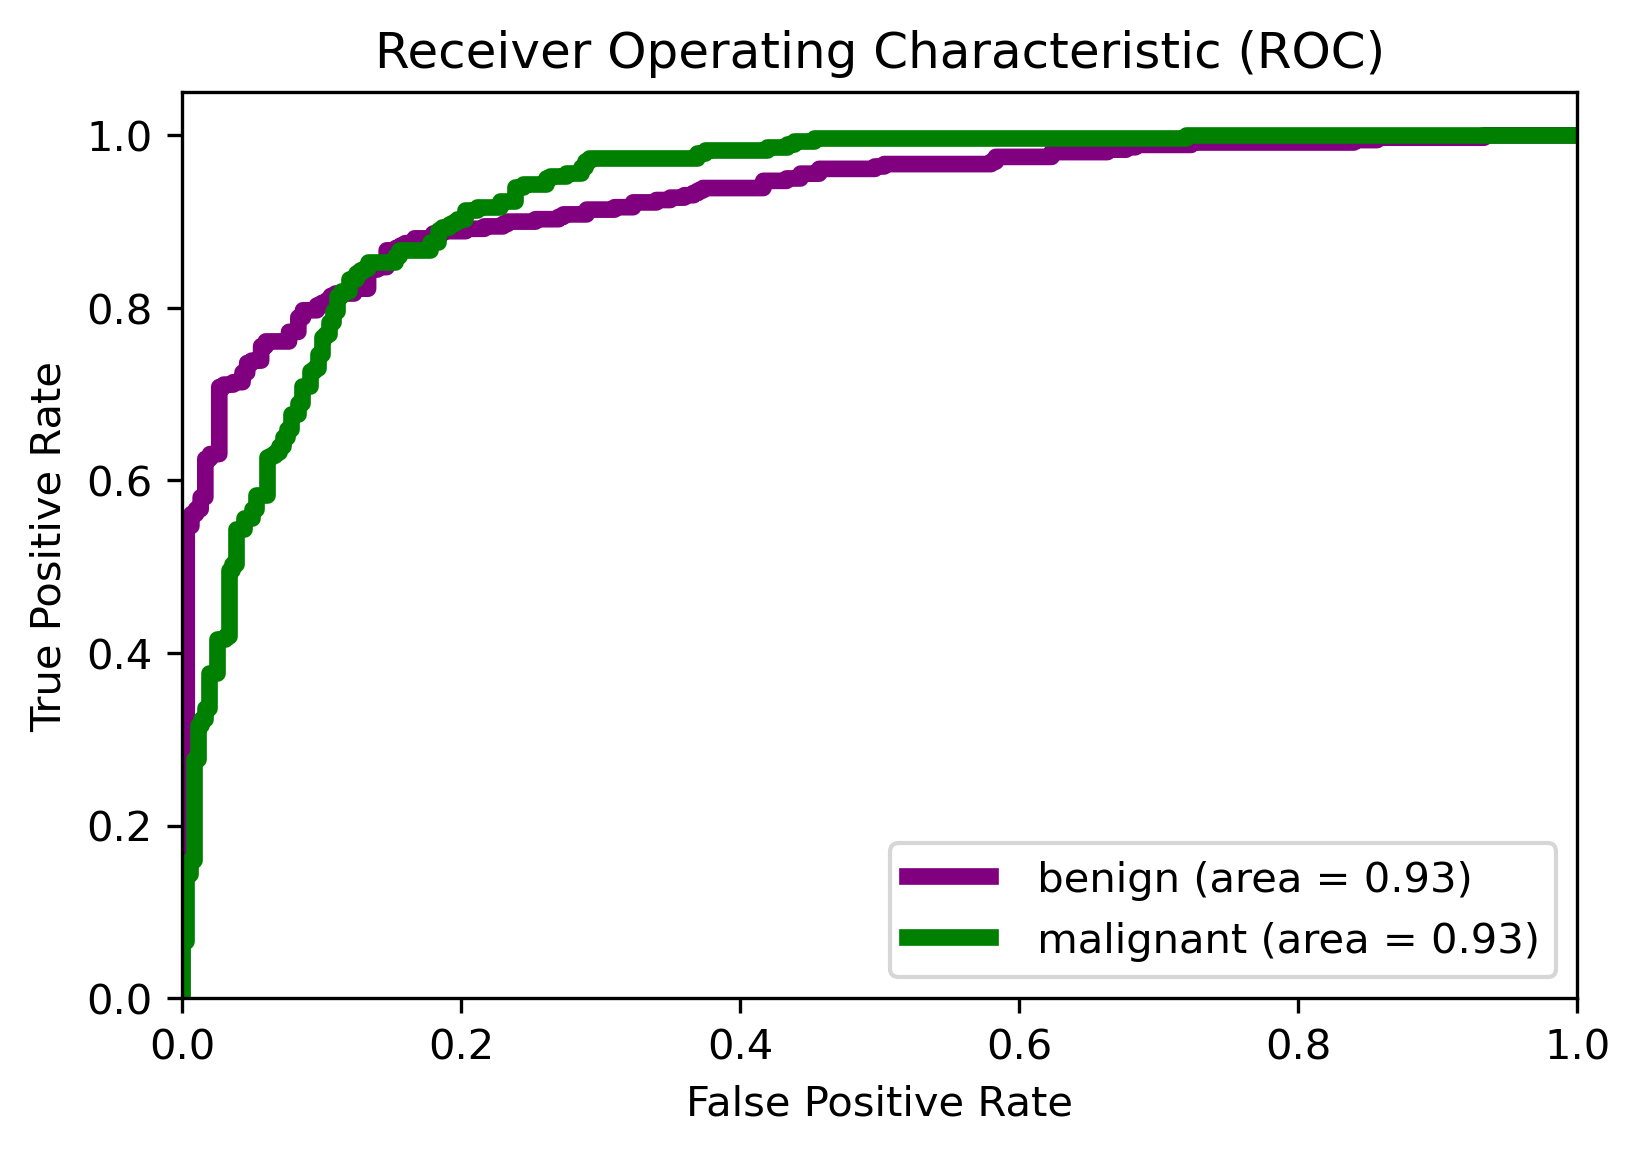

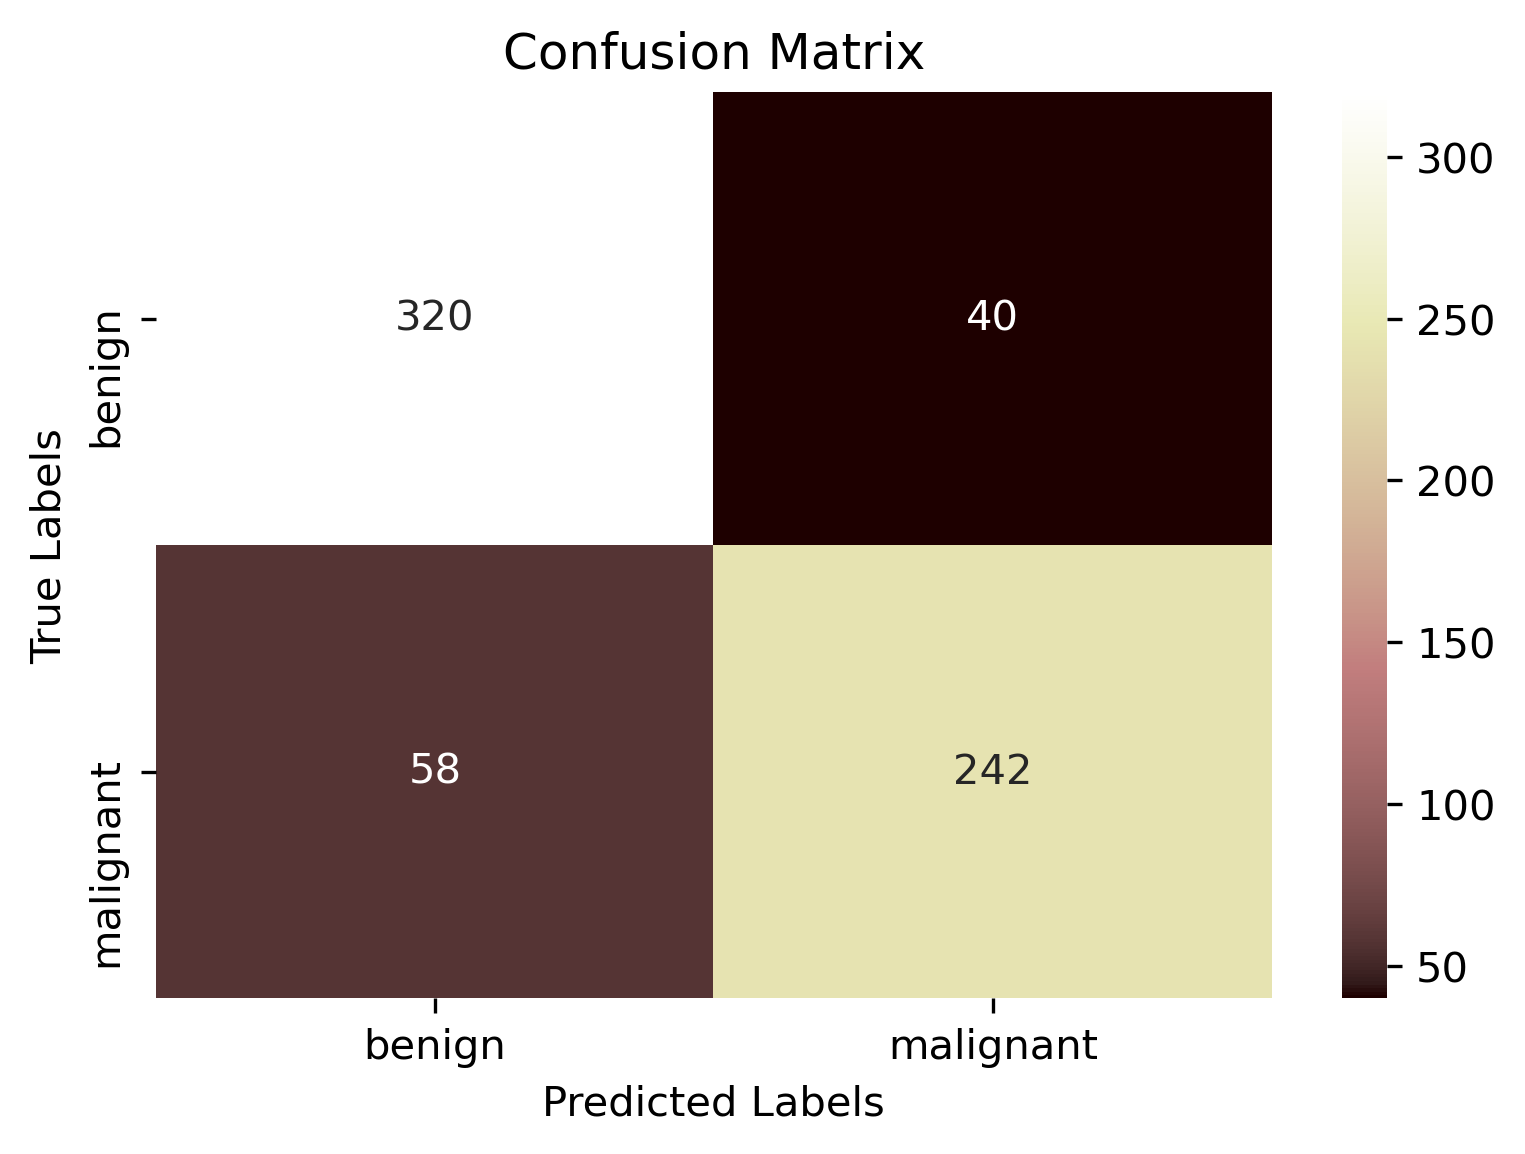

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       360
           1       0.86      0.81      0.83       300

    accuracy                           0.85       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.85      0.85      0.85       660



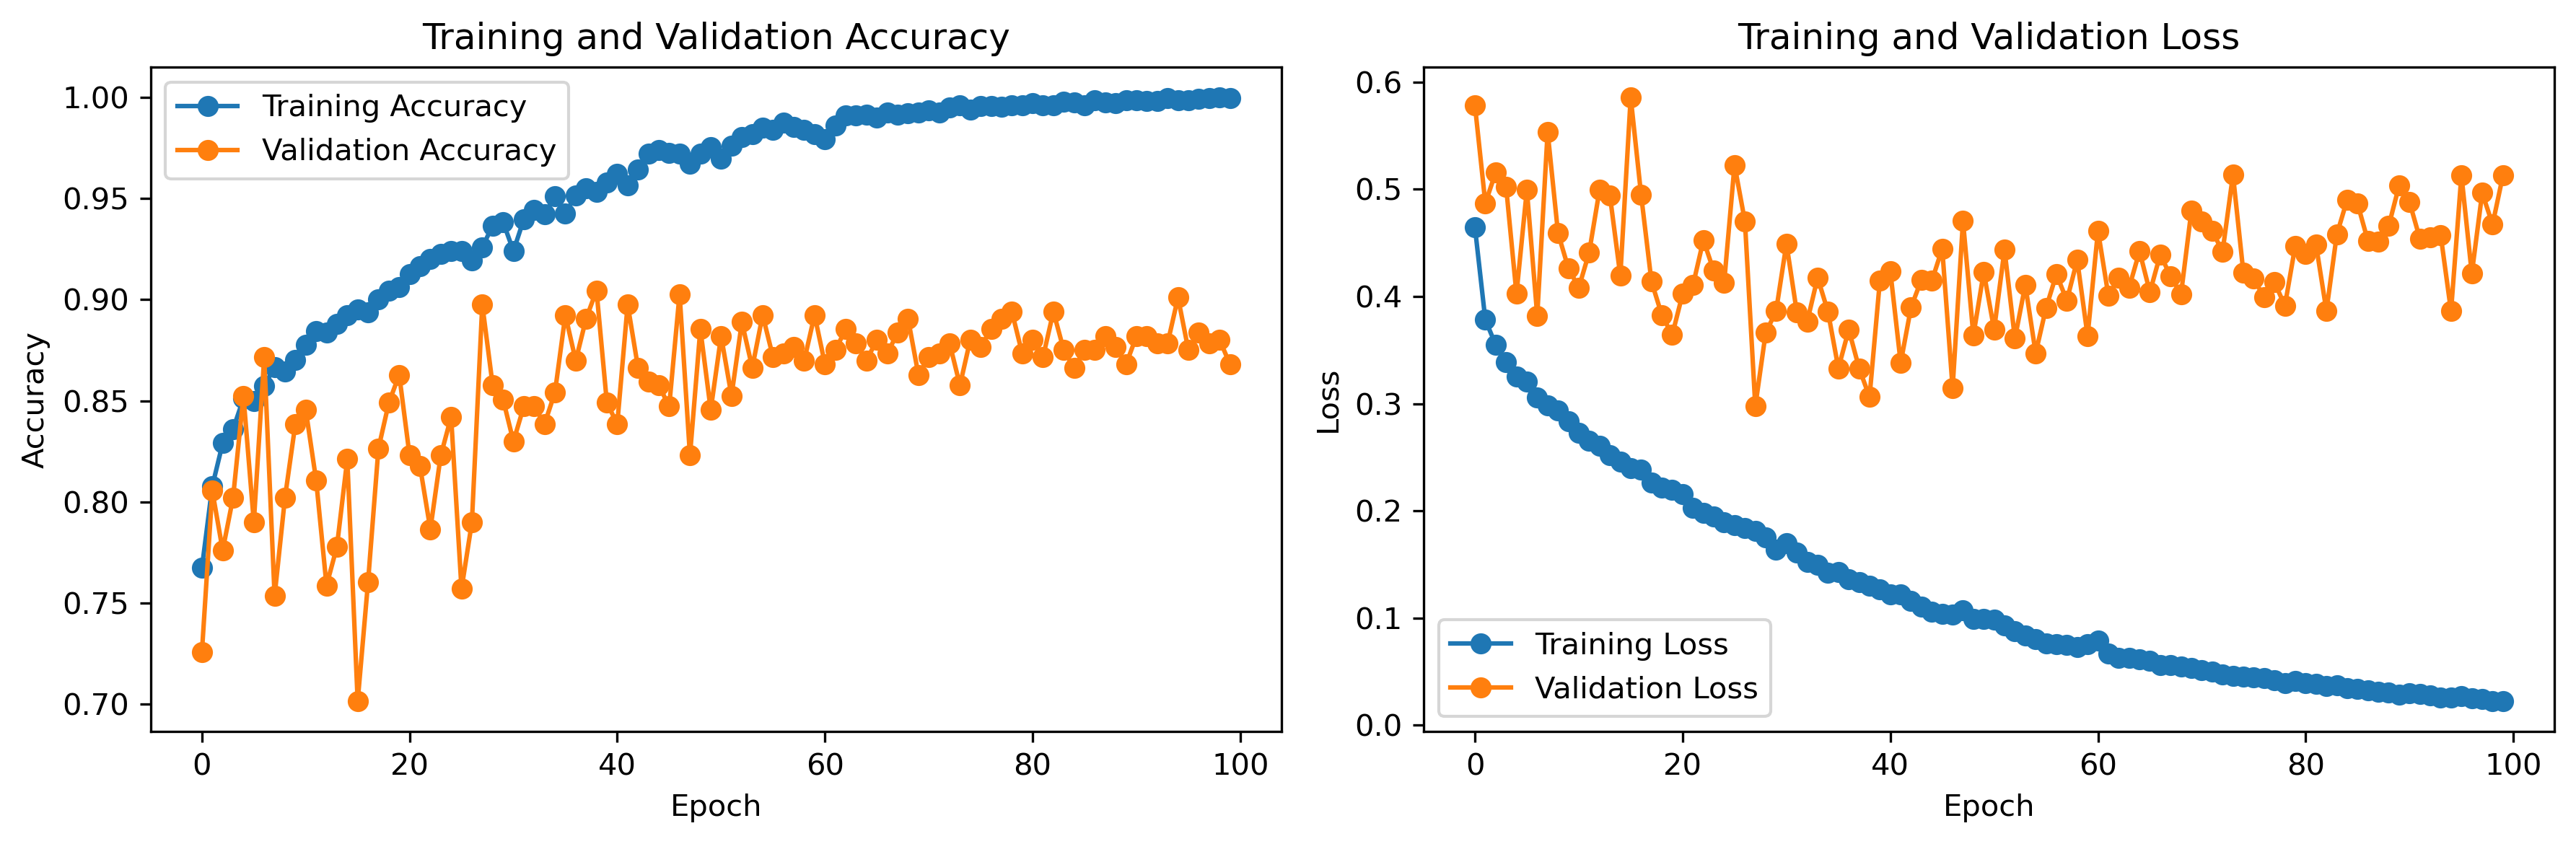

In [23]:

#classfication using normal elm-isic2017-85.75
# Flatten the extracted features
# Extract features from the autoencoder for both training and test sets
train_features = encoder.predict(train_images)
test_features = encoder.predict(test_images)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)
epochs=100
# Define the ELM model
def build_elm():
    input_dim = train_features_flat.shape[1]  # Use the flattened feature shape
    hidden_dim = 64  # You can adjust the number of hidden neurons
    output_dim = 2  # 2 classes for binary classification

    input_layer = Input(shape=(input_dim,))
    hidden_layer = Dense(hidden_dim, activation='sigmoid')(input_layer)
    output_layer = Dense(output_dim, activation='softmax')(hidden_layer)

    elm_model = Model(inputs=input_layer, outputs=output_layer)
    elm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return elm_model

# Build and train the ELM model
elm_model = build_elm()
elm_model.summary()

# Convert labels to one-hot encoding for ELM
train_labels_one_hot = train_labels
test_labels_one_hot = test_labels

# Train the ELM model on the flattened extracted features
history_elm = elm_model.fit(train_features_flat, train_labels_one_hot, epochs=epochs, batch_size=128, validation_split=0.2)

# Evaluate the ELM model on the test set
test_loss, test_accuracy = elm_model.evaluate(test_features_flat, test_labels_one_hot)
print(test_accuracy)

####################################################################################################
#####printing results for elm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
test_predictions_prob = elm_model.predict(test_features_flat)

# Compute ROC curve and ROC area for each class
n_classes = 2  # You mentioned 7 output classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], test_predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names
class_names = ['benign', 'malignant']

# Define colors for each class
colors = ['purple', 'green' ]  # You can adjust the colors

# Plot ROC curve for each class with class names in the legend
plt.figure(figsize=(6, 4))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4, label=f' {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Compute confusion matrix
test_predictions = np.argmax(test_predictions_prob, axis=1)
test_true_labels = np.argmax(test_labels_one_hot, axis=1)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Display confusion matrix
class_names = ['benign','malignant']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4),dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='pink', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = elm_model.predict(test_features_flat)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels_one_hot, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Print classification report
report = classification_report(test_true_labels, test_pred_labels)
print(report)


######################3333
import matplotlib.pyplot as plt

# Get the training history
train_loss = history_elm.history['loss']
val_loss = history_elm.history['val_loss']
train_acc = history_elm.history['accuracy']
val_acc = history_elm.history['val_accuracy']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 4),dpi=300)

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
''''
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier  # You can choose a different base classifier

# Define the K-ELM model for multi-label classification
def build_kernel_elm_multi_label():
    input_dim = train_features_flat.shape[1]  # Use the flattened feature shape
    output_dim = 2  # Adjust based on your number of classes

    # Use an RBF (Radial Basis Function) kernel approximation
    rbf_feature = RBFSampler(gamma=1, random_state=1, n_components=100)
    
    # Create a Ridge Classifier as the base estimator
    base_estimator = RidgeClassifier(alpha=1.0)
    
    # Create a MultiOutputClassifier with the base estimator
    elm_model = MultiOutputClassifier(base_estimator)
    return elm_model

# Build and train the K-ELM model for multi-label classification
kernel_elm_model_multi_label = build_kernel_elm_multi_label()
kernel_elm_model_multi_label.fit(train_features_flat, train_labels)

# Predict on the test set
test_predictions = kernel_elm_model_multi_label.predict(test_features_flat)

# Calculate accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)


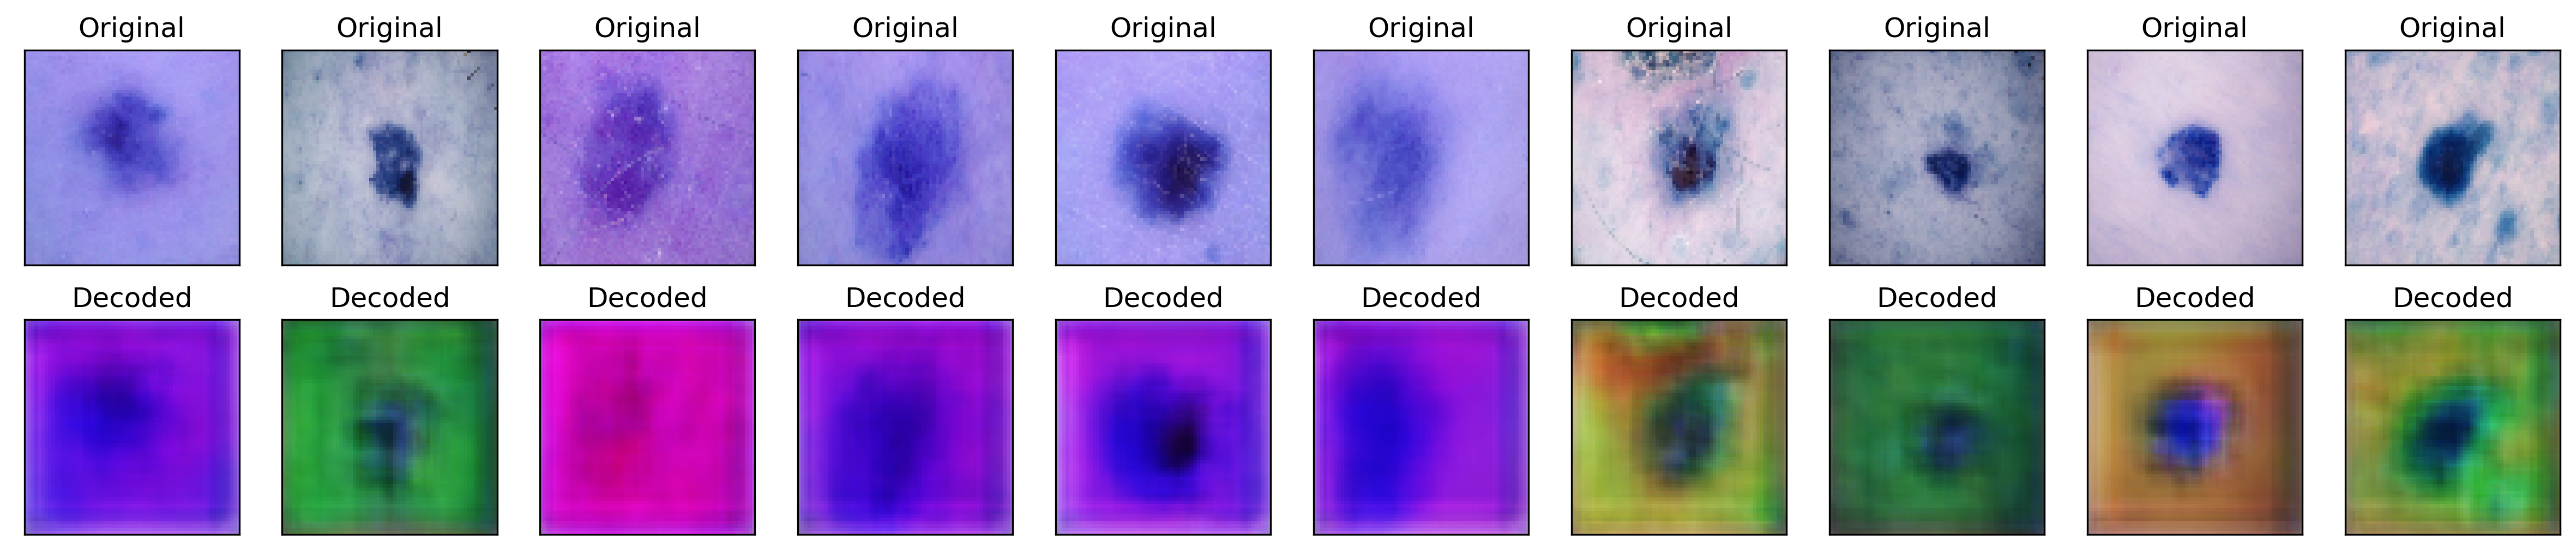

21/21 [==============================] - 0s 4ms/step - loss: 0.3824 - accuracy: 0.8621
Test Accuracy: 0.8621212244033813


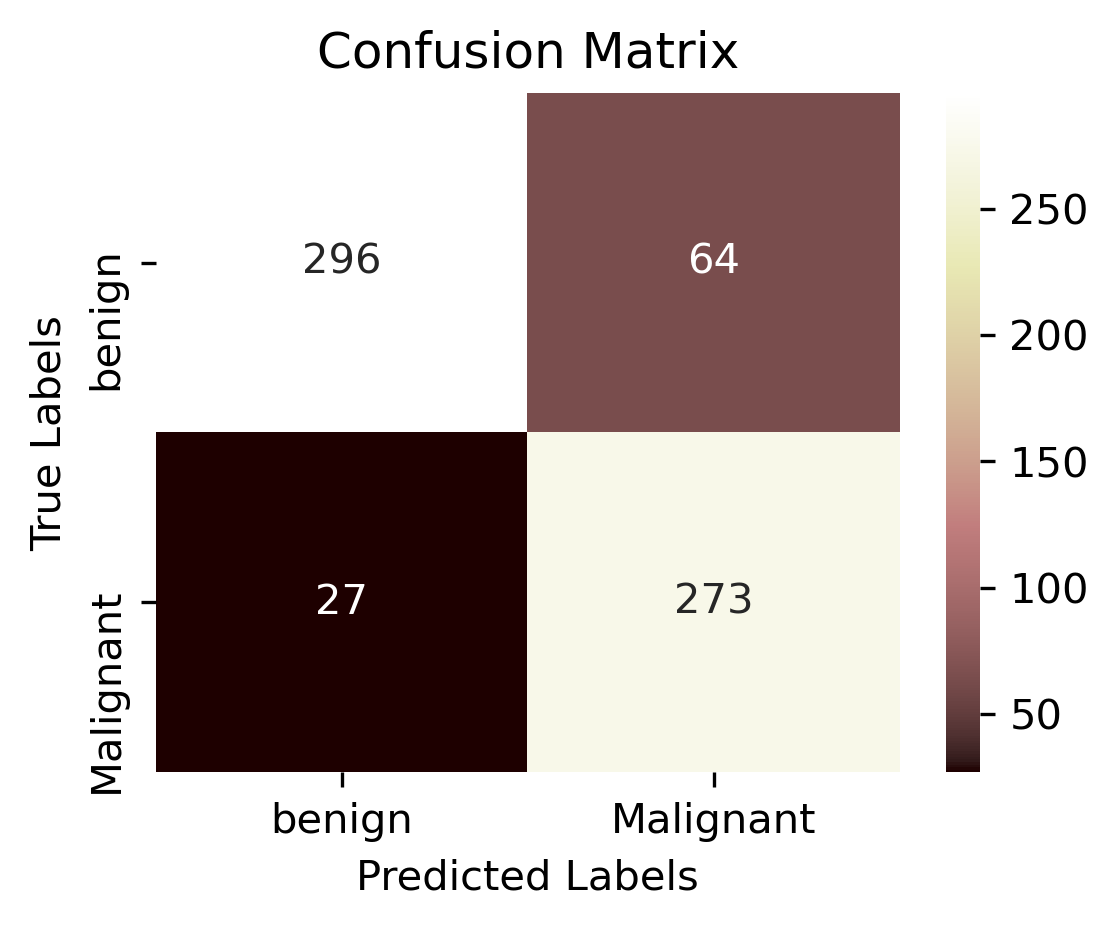

(660, 2)


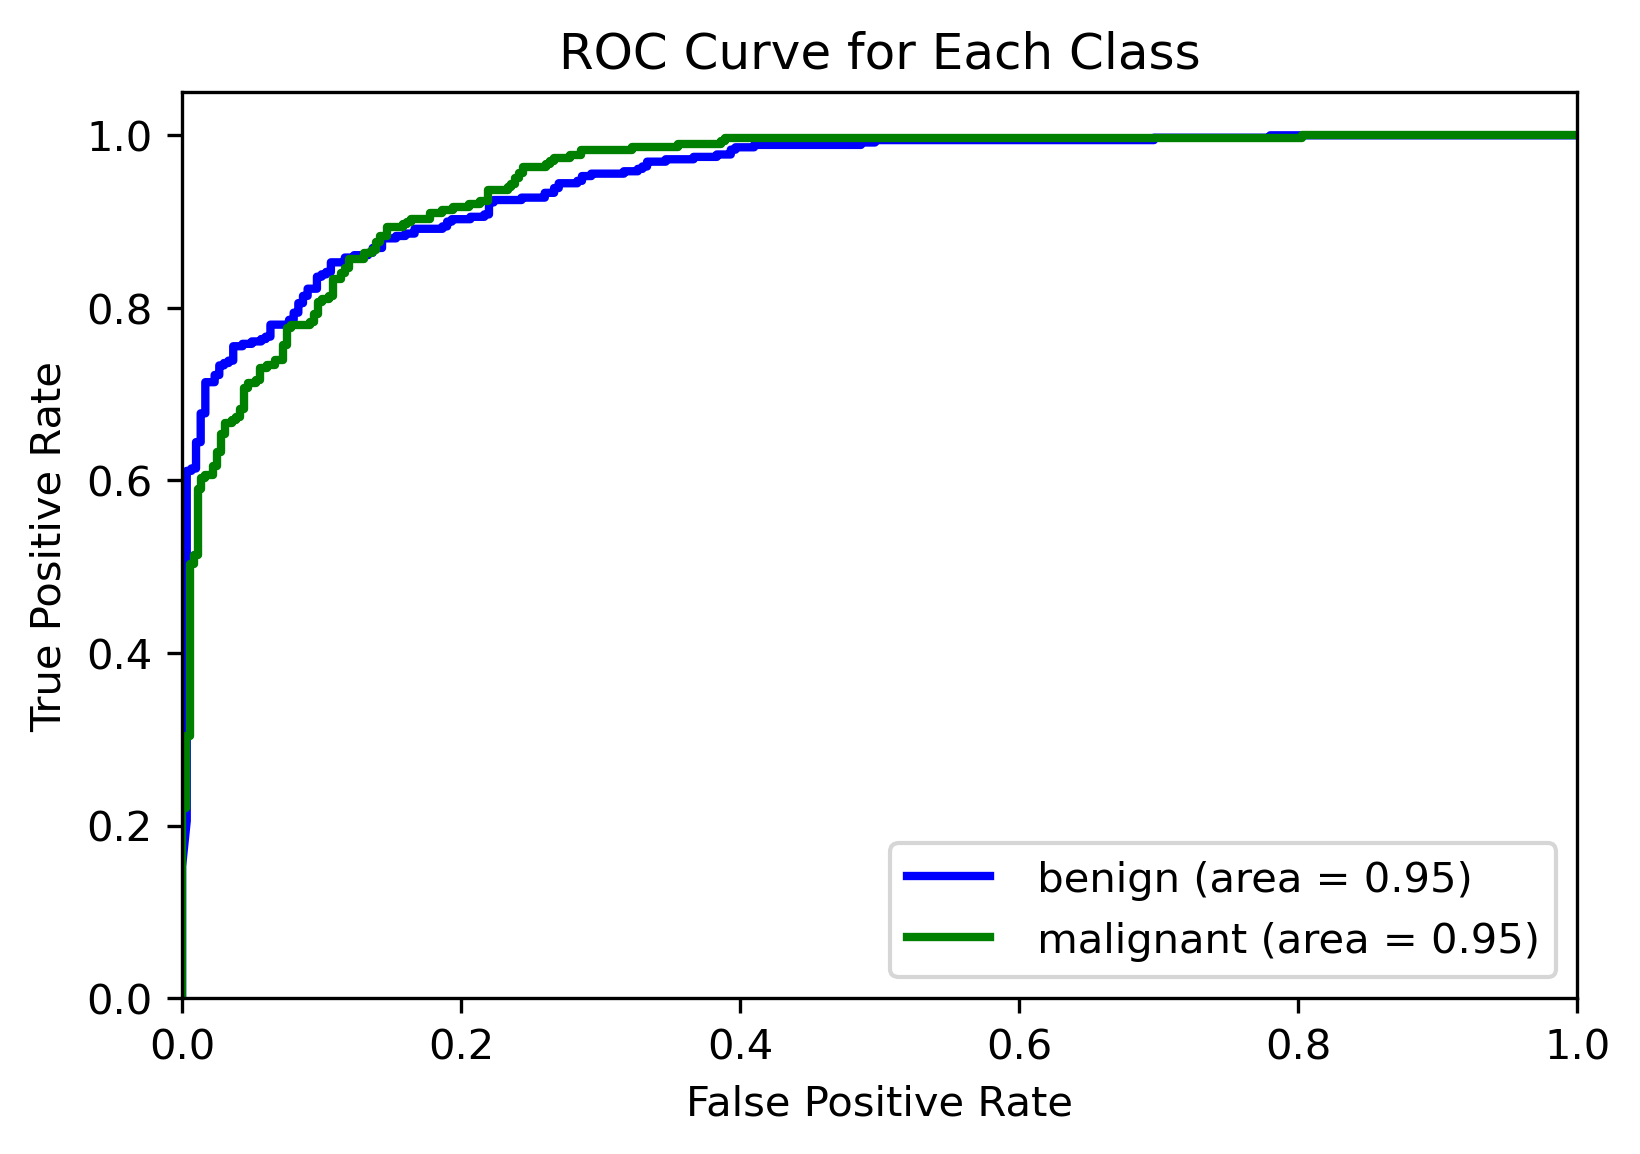

21/21 [==============================] - 0s 4ms/step - loss: 0.3824 - accuracy: 0.8621
Test Accuracy: 0.8621212244033813
              precision    recall  f1-score   support

      benign       0.92      0.82      0.87       360
   Malignant       0.81      0.91      0.86       300

    accuracy                           0.86       660
   macro avg       0.86      0.87      0.86       660
weighted avg       0.87      0.86      0.86       660



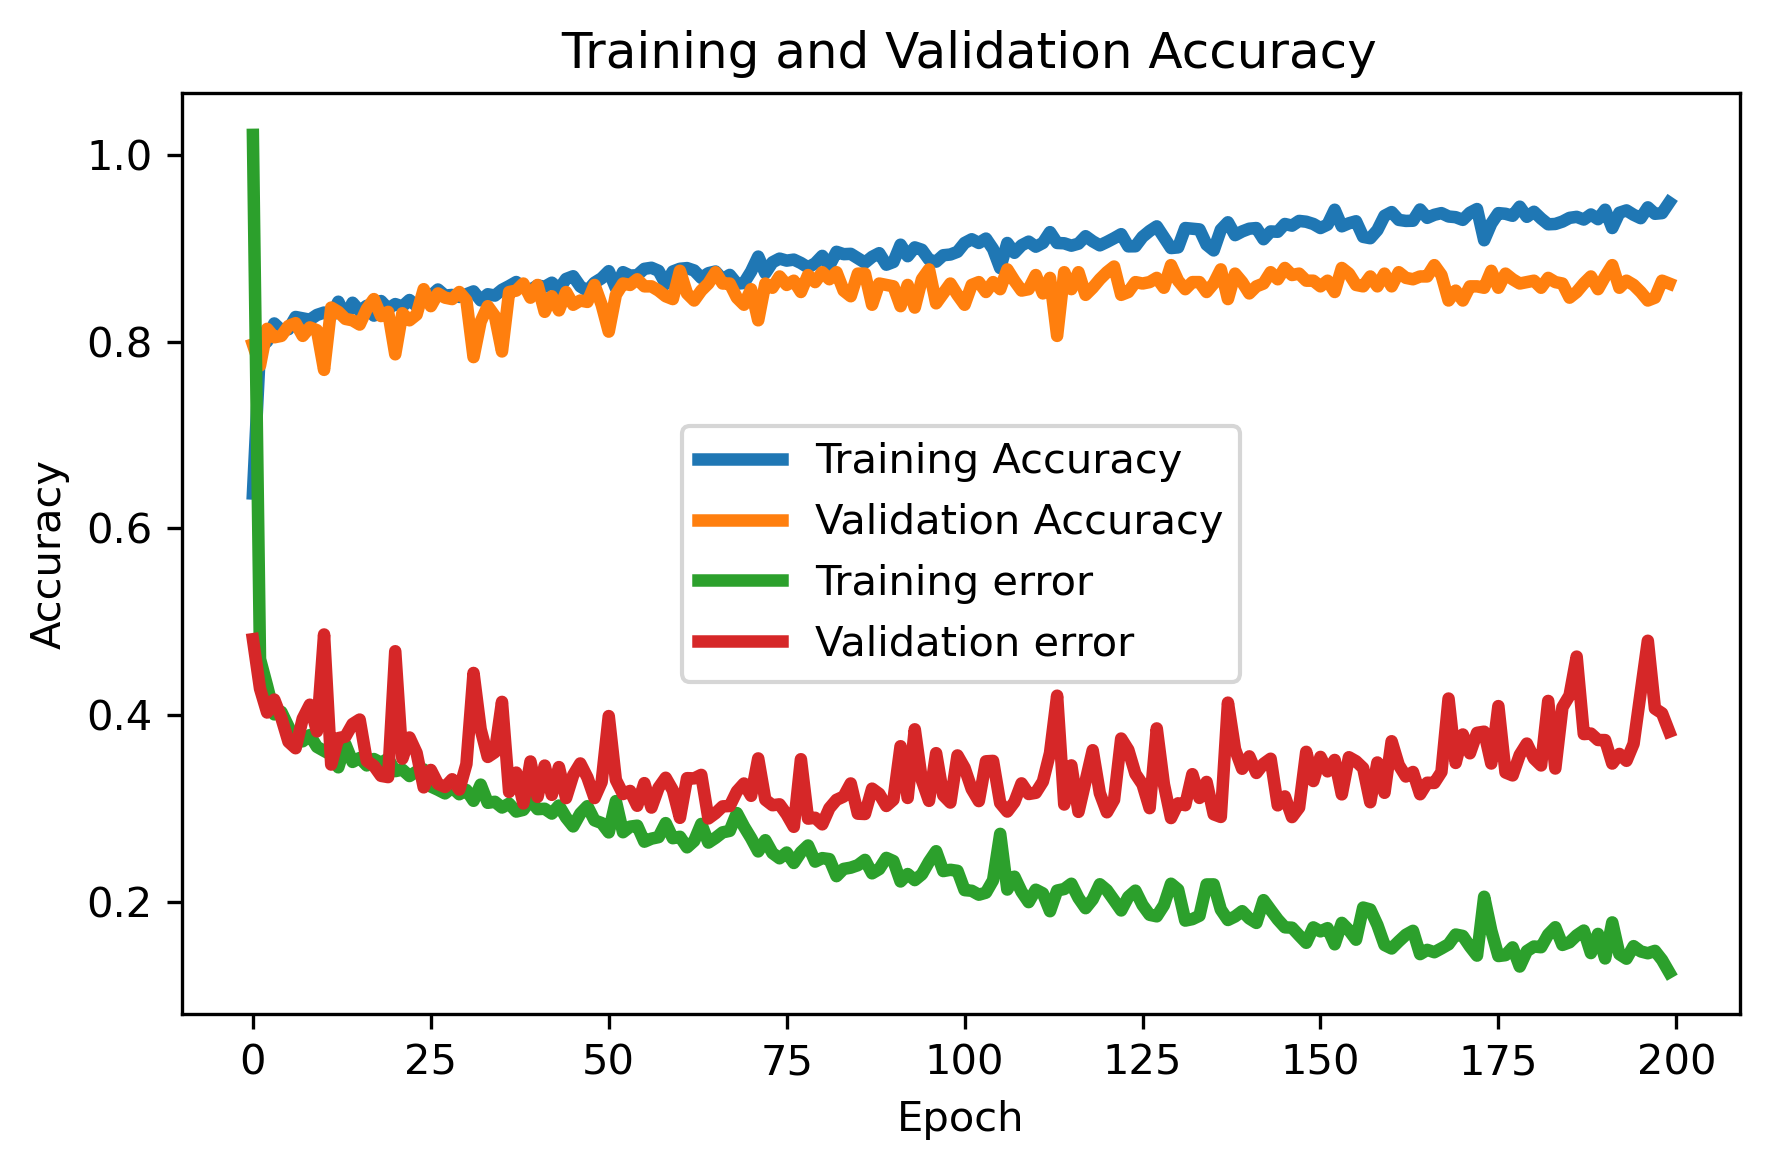

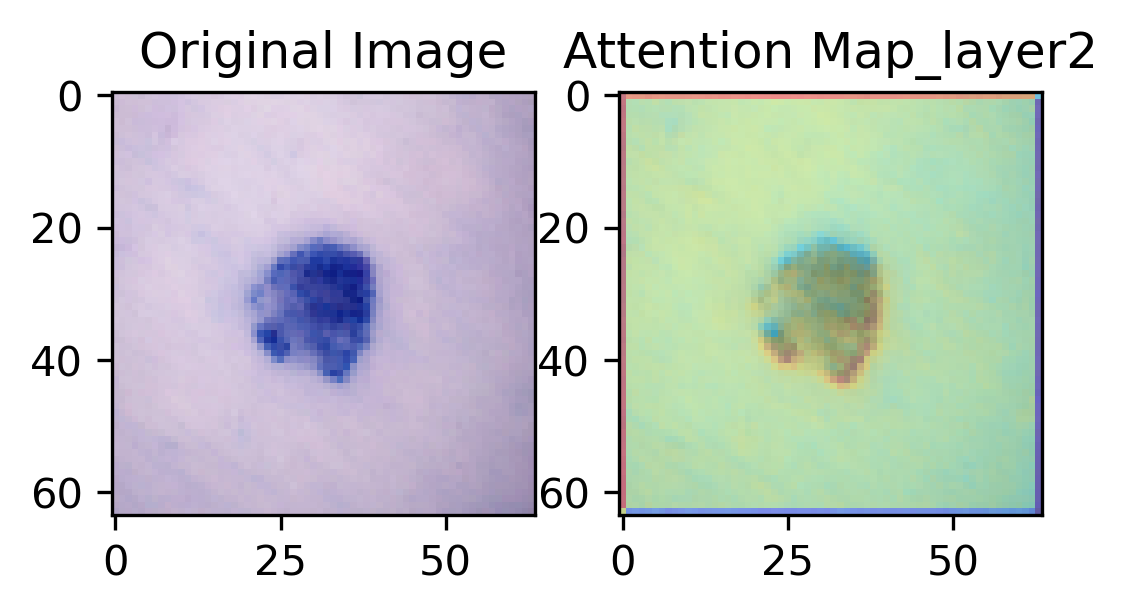

attention layer (32, 32)
sample image (64, 64, 3)


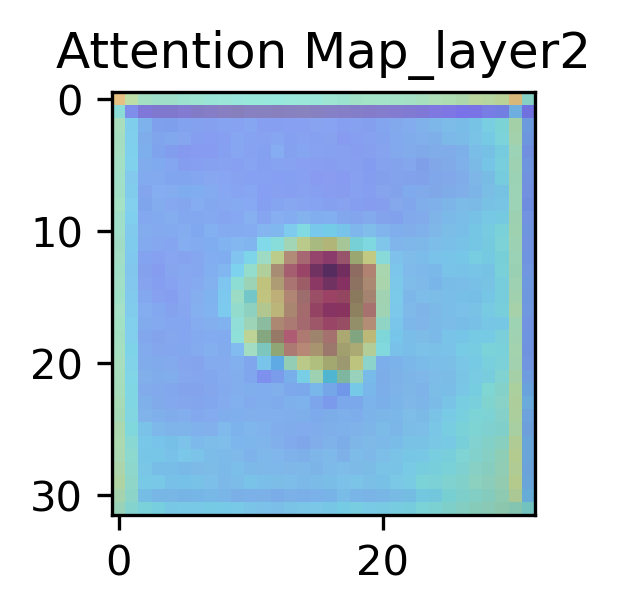

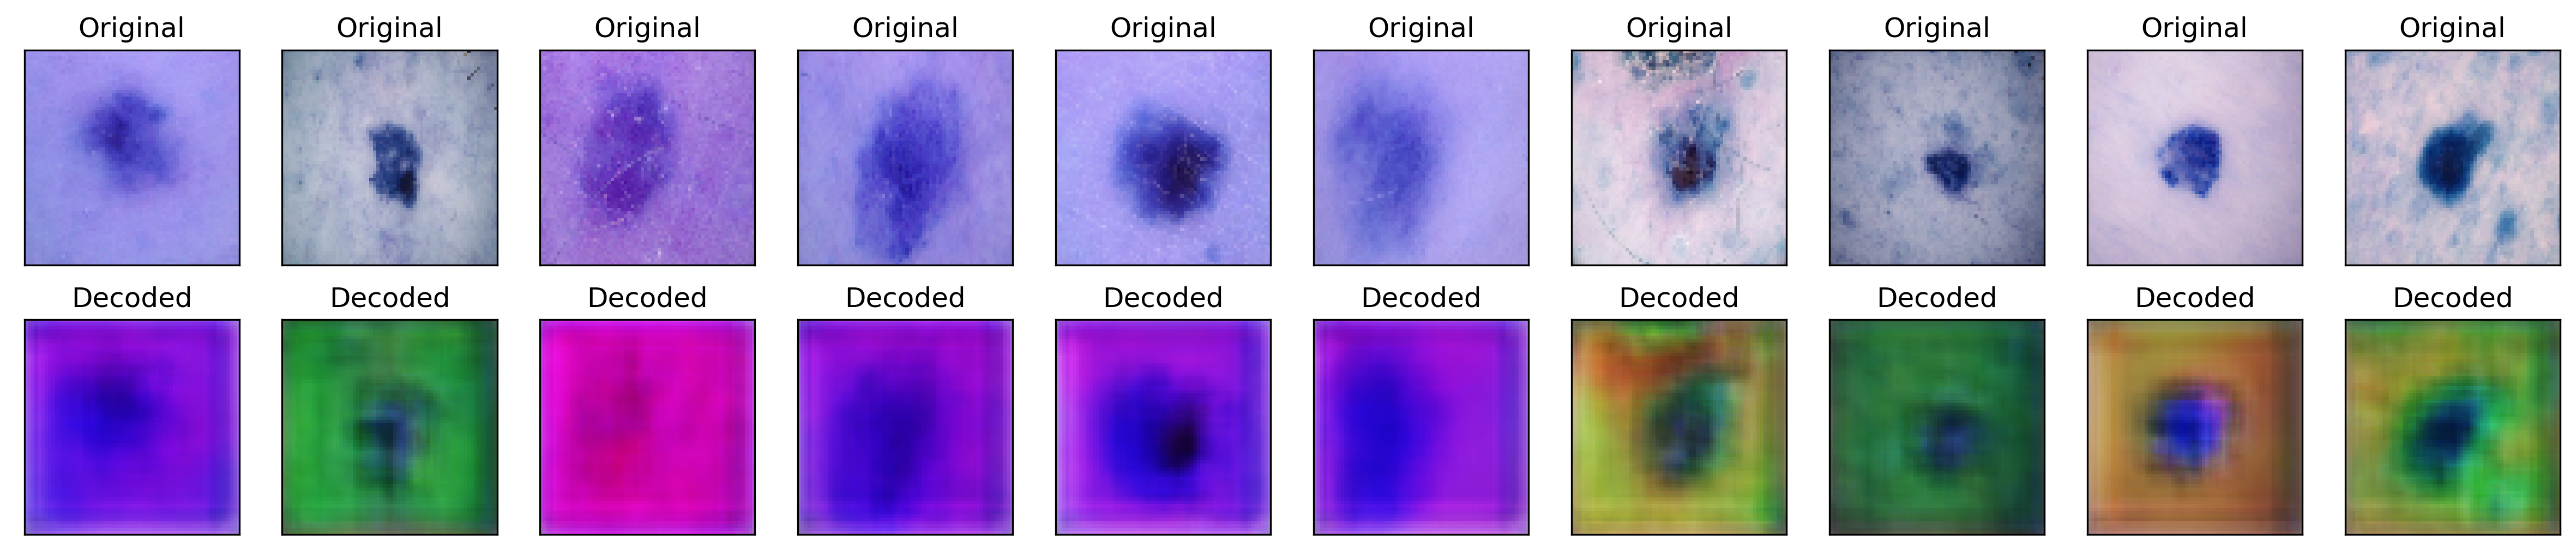

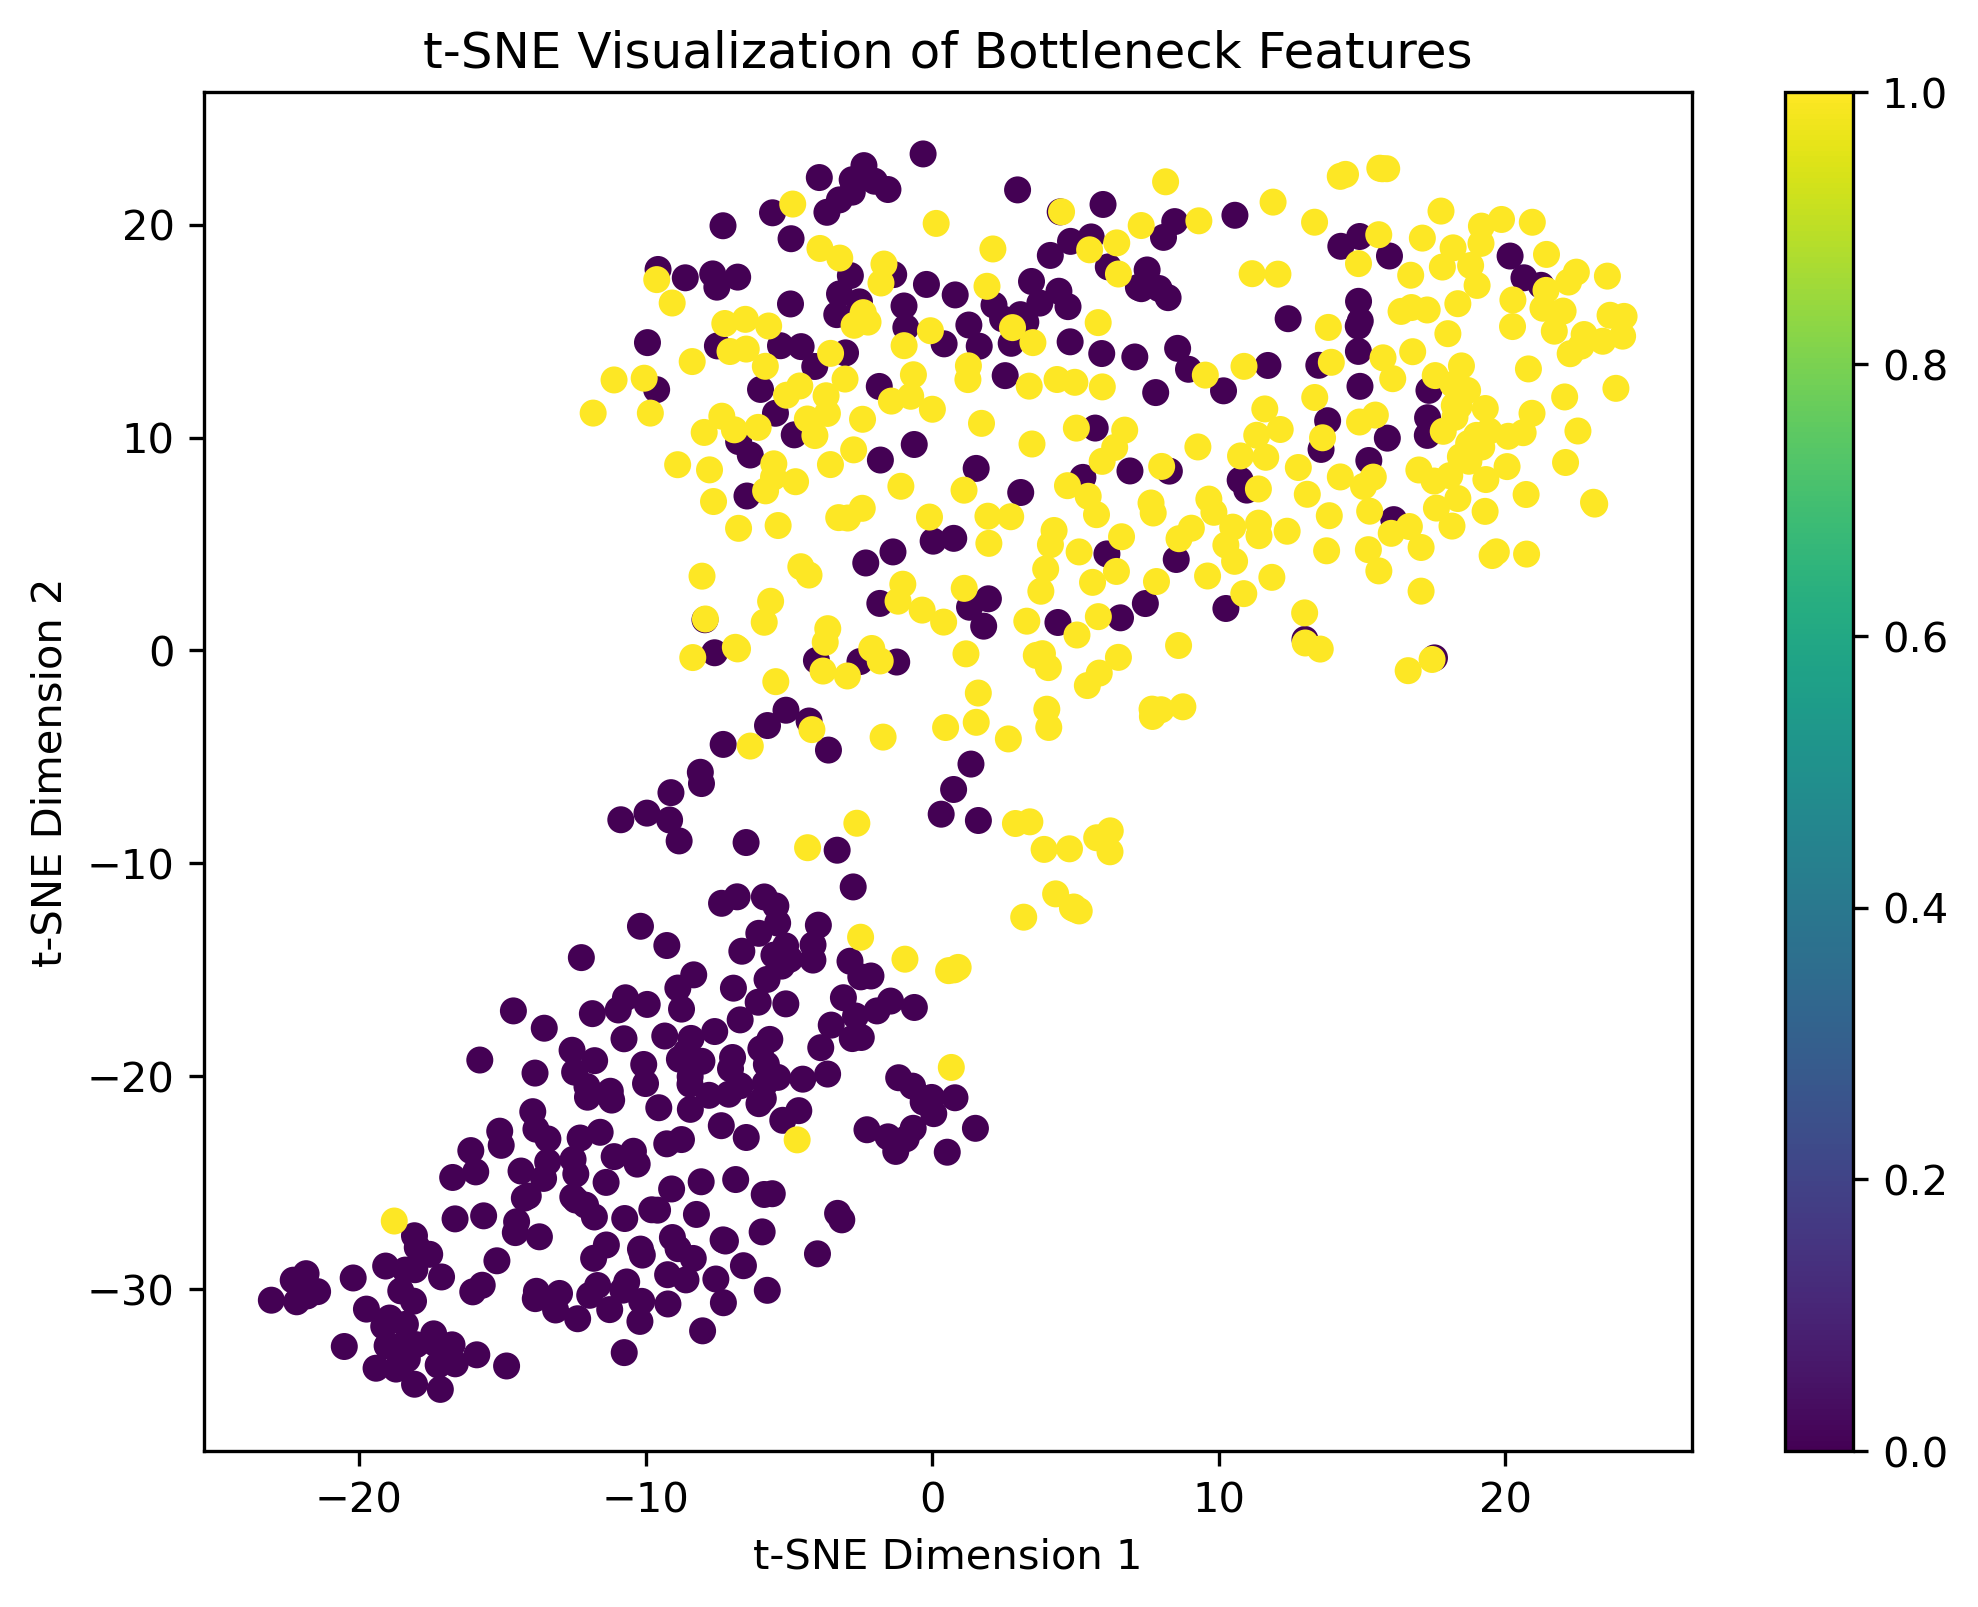

In [25]:

#results for ISIC dataset
#visualise decoded images
import matplotlib.pyplot as plt

# Function to visualize the original and decoded images
def visualize_decoded_images(autoencoder, test_images):
    n_images = 10
    decoded_images = autoencoder.predict(test_images)

    plt.figure(figsize=(20, 4),dpi=300)
    for i in range(n_images):
        # Original Images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Decoded Images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(decoded_images[i])
        plt.title("Decoded")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Assuming you have the test_images variable with your test data
visualize_decoded_images(autoencoder, test_images)



####
#confusion matrix
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


(train_images, train_labels), (test_images, test_labels) = (X_train, Y_train), (X_test, Y_test)

# Normalize and preprocess the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=2)
test_labels = to_categorical(test_labels, num_classes=2)

# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)
class_names = ['benign', 'Malignant']
# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(4, 3),dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='pink', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#plot ROC curve
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
print(test_labels.shape)
# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Compute ROC curve and AUC for each class
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4),dpi=300)
colors = cycle(['blue', 'green'])
for i, color in zip(range(n_classes), colors):
    class_label = "benign" if i == 0 else "malignant"
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=' {0} (area = {1:0.2f})'.format(class_label, roc_auc[i]))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

#classification performance for each class
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

epochs = 100

# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute classification report
class_names = ['benign', 'Malignant']
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

#This code will display two subplots, one for the autoencoder's training and validation accuracy and another for the classifier's training and validation accuracy. You can observe how the accuracy changes during the training process for both models.
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,4))
plt.plot(history_classifier.history['accuracy'],lw=3, label='Training Accuracy',)
plt.plot(history_classifier.history['val_accuracy'],lw=3, label='Validation Accuracy')
plt.plot(history_classifier.history['loss'],lw=3, label='Training error')
plt.plot(history_classifier.history['val_loss'],lw=3, label='Validation error')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(' Training and Validation Accuracy')

plt.tight_layout()
plt.show()


#visualising attention maps
import numpy as np
import matplotlib.pyplot as plt

# Select a sample image from the test set
sample_image = test_images[8]

# Get the attention layer from the autoencoder
attention_layer = autoencoder.get_layer('channel_attention_4')

# Create a model to get the output of the attention layer
attention_model = Model(inputs=autoencoder.input, outputs=attention_layer.output)

# Get the attention maps for the sample image
attention_maps = attention_model.predict(np.expand_dims(sample_image, axis=0))

# Plot the original image and its corresponding attention map
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(attention_maps[0, :, :, 0], cmap='jet', alpha=0.8)
plt.imshow(sample_image, alpha=0.5)
plt.title('Attention Map_layer2')

plt.show()

######33printing second attention layer

# Get the attention layer from the autoencoder
attention_layer = autoencoder.get_layer('channel_attention_5')

# Create a model to get the output of the attention layer
attention_model = Model(inputs=autoencoder.input, outputs=attention_layer.output)

# Get the attention maps for the sample image
attention_maps = attention_model.predict(np.expand_dims(sample_image, axis=0))

# Plot the original image and its corresponding attention map
plt.figure(figsize=(4, 4))
sample_image_resized = cv2.resize(sample_image, (32, 32))

plt.subplot(1, 2, 1)
plt.imshow(attention_maps[0, :, :, 0], cmap='jet', alpha=0.8)
print("attention layer",attention_maps[0, :, :, 0].shape)
print("sample image",sample_image.shape)

plt.imshow(sample_image_resized, alpha=0.5)
plt.title('Attention Map_layer2')

plt.show()
#########################

#visualise decoded images
import matplotlib.pyplot as plt

# Function to visualize the original and decoded images
def visualize_decoded_images(autoencoder, test_images):
    n_images = 10
    decoded_images = autoencoder.predict(test_images)

    plt.figure(figsize=(20, 4),dpi=300)
    for i in range(n_images):
        # Original Images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Decoded Images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(decoded_images[i])
        plt.title("Decoded")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Assuming you have the test_images variable with your test data
visualize_decoded_images(autoencoder, test_images)

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a model to get the bottleneck/encoded features
bottleneck_model = Model(inputs=autoencoder.input, outputs=encoder.output)

# Get the encoded features for the test images
encoded_features = bottleneck_model.predict(test_images)

# Flatten the encoded features to 2D for t-SNE
encoded_features_flattened = encoded_features.reshape(encoded_features.shape[0], -1)

# Function to visualize t-SNE plot
def visualize_tsne(encoded_features, labels):
    # Reduce the dimensionality of encoded features using t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    encoded_features_tsne = tsne.fit_transform(encoded_features)

    # Map the labels to a continuous range of integers
    label_indices = np.argmax(labels, axis=1)

    # Create a scatter plot for visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(encoded_features_tsne[:, 0], encoded_features_tsne[:, 1], c=label_indices, cmap='viridis', s=30)

    plt.colorbar()
    plt.title('t-SNE Visualization of Bottleneck Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Assuming your test_labels contain the true labels for the test images
# Replace test_labels with the appropriate variable containing the true labels
visualize_tsne(encoded_features_flattened, test_labels)



In [ ]:
print(autoencoder.summary())

<h3>The skin cancer single channel CSV</h3>

In [ ]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')

**Reference**: The corresponding categorical labels for the numeric labels in the skin canceer dataset:

<ol>
    <li>akiec</li>
    <li>bcc</li>
    <li>bkl</li>
    <li>df</li>
    <li>mel</li>
    <li>nv</li>
    <li>vasc</li>
</ol>

In [ ]:
classes = { 0:'akiec',1:'bcc', 2 :'bkl',3:'df',4: 'mel',5:'nv', 6:'vasc'}

In [ ]:
df.head()

In [ ]:
df.shape

<h3>Division of data and labels</h3>

We will proceed to separate out the data used for training as well as the labels, these will be separately used in our model creation phase

In [ ]:
df_x = df.loc[:,'pixel0000':'pixel2351']

In [ ]:
df_x

In [ ]:
df_y = df.loc[:,'label']

In [ ]:
df_y

### oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()
df_x,df_y  = oversample.fit_resample(df_x,df_y)
df_x= np.array(df_x).reshape(-1,28,28,3)
print('Shape of X :',df_x.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_x,df_y, test_size=0.2, random_state=1)

In [ ]:
np_x_train = np.array(X_train)
np_x_test = np.array(X_test)
print(np_x_train.shape)
(np_x_test.shape)

<h3>Training data reshape</h3>

As our data is in the format of `28x28` images, we will proceed to reshape them accordingly. This will result in a 3-D array with dimensions:

(Number of training samples, height, width)

In [ ]:
X_train = np.array(np_x_train).reshape(-1,28, 28,3)
X_test = np.array(np_x_test).reshape(-1,28, 28,3)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

80% training , 20% testing

In [ ]:
print("training",X_train.shape)
print(Y_train.shape)
print("testing",X_test.shape)
print(Y_test.shape)

In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes=7
y_train = to_categorical(Y_train, num_classes=num_classes)
y_test = to_categorical(Y_test, num_classes=num_classes)
print(y_train.shape)
print(y_test.shape)

In [ ]:
'''
#without dataaugmentation HAM10000
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical

epochs = 100

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = (X_train, Y_train), (X_test, Y_test)

# Normalize and preprocess the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

# Define the ChannelAttention layer
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.attention = Dense(1, activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        channel_weights = self.attention(avg_pool)
        return inputs * channel_weights

# Define the autoencoder model with ChannelAttention
def build_autoencoder():
    input_img = Input(shape=(64, 64, 3))
    # Encoder with ChannelAttention
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(input_img)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Train the autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()
history_autoencoder = autoencoder.fit(train_images, train_images, epochs=epochs, batch_size=128, validation_split=0.2)

# Get the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[5].output)

# Define the classification model on top of the encoder with ChannelAttention
def build_classifier(encoder):
    inputs = Input(shape=(64, 64, 3))
    # Use the encoder to get the features with ChannelAttention
    features = encoder(inputs)
    print(features.shape)
    x = Flatten()(features)
    x = Dense(128, activation='selu')(x)
    x = Dense(64, activation='selu')(x)
    outputs = Dense(2, activation='softmax')(x)
    classifier = Model(inputs=inputs, outputs=outputs)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

# Build the classifier on top of the encoder with ChannelAttention
classifier = build_classifier(encoder)

# Train the classifier on the encoded features
history_classifier = classifier.fit(train_images, train_labels, epochs=epochs, batch_size=128, validation_split=0.2)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print(test_accuracy)


In [ ]:

#with data augmentation-HAM10000
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical

epochs = 200

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = (X_train, Y_train), (X_test, Y_test)

# Normalize and preprocess the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

# Define the ChannelAttention layer
class ChannelAttention(Layer):
    def __init__(self):
        super(ChannelAttention, self).__init__()

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.attention = Dense(1, activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=[1, 2], keepdims=True)
        channel_weights = self.attention(avg_pool)
        return inputs * channel_weights

# Define the autoencoder model with ChannelAttention
def build_autoencoder():
    input_img = Input(shape=(28, 28, 3))
    # Encoder with ChannelAttention
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(input_img)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = ChannelAttention()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='selu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder


# Train the autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()
# Train the autoencoder with data augmentation
history_autoencoder = autoencoder.fit(
    datagen.flow(train_images, train_images, batch_size=128),
    steps_per_epoch=len(train_images) // 128,
    epochs=epochs,
    validation_data=(train_images, train_images)
)
# Get the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[5].output)
print("Encoder Layer Name:", autoencoder.layers[5].name)
# Define the classification model on top of the encoder with ChannelAttention
def build_classifier(encoder):
    inputs = Input(shape=(28, 28, 3))
    # Use the encoder to get the features with ChannelAttention
    features = encoder(inputs)
    print("feature shape",features.shape)
    x = Flatten()(features)
    x = Dense(128, activation='selu')(x)
    x = Dense(64, activation='selu')(x)
    outputs = Dense(7, activation='softmax')(x)
    classifier = Model(inputs=inputs, outputs=outputs)
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return classifier

# Build the classifier on top of the encoder with ChannelAttention
classifier = build_classifier(encoder)

# Train the classifier on the encoded features with data augmentation
history_classifier = classifier.fit(
    datagen.flow(train_images, train_labels, batch_size=128),
    steps_per_epoch=len(train_images) // 128,
    epochs=epochs,
    validation_data=(test_images, test_labels)
)
# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print(test_accuracy)

In [ ]:

#classfication using normal elm-ham1000-85.75
# Flatten the extracted features
# Extract features from the autoencoder for both training and test sets
train_features = encoder.predict(train_images)
test_features = encoder.predict(test_images)
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)
epochs=100
# Define the ELM model
def build_elm():
    input_dim = train_features_flat.shape[1]  # Use the flattened feature shape
    hidden_dim = 128  # You can adjust the number of hidden neurons
    output_dim = 7  # 2 classes for binary classification

    input_layer = Input(shape=(input_dim,))
    hidden_layer = Dense(hidden_dim, activation='sigmoid')(input_layer)
    output_layer = Dense(output_dim, activation='softmax')(hidden_layer)

    elm_model = Model(inputs=input_layer, outputs=output_layer)
    elm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return elm_model

# Build and train the ELM model
elm_model = build_elm()
elm_model.summary()

# Convert labels to one-hot encoding for ELM
train_labels_one_hot = train_labels
test_labels_one_hot = test_labels

# Train the ELM model on the flattened extracted features
history_elm = elm_model.fit(train_features_flat, train_labels_one_hot, epochs=epochs, batch_size=128, validation_split=0.2)

# Evaluate the ELM model on the test set
test_loss, test_accuracy = elm_model.evaluate(test_features_flat, test_labels_one_hot)
print(test_accuracy)

####################################################################################################
#####printing results for elm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for each class
test_predictions_prob = elm_model.predict(test_features_flat)

# Compute ROC curve and ROC area for each class
n_classes = 7  # You mentioned 7 output classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], test_predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Define colors for each class
colors = ['darkorange', 'cornflowerblue', 'purple', 'green', 'red', 'brown', 'yellow']  # You can adjust the colors

# Plot ROC curve for each class with class names in the legend
plt.figure(figsize=(6, 4))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4, label=f' {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


# Compute confusion matrix
test_predictions = np.argmax(test_predictions_prob, axis=1)
test_true_labels = np.argmax(test_labels_one_hot, axis=1)
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Display confusion matrix
class_names = ['akiec', 'bcc','bkl','df', 'mel','nv','vasc']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4),dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='pink', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = elm_model.predict(test_features_flat)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels_one_hot, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Print classification report
report = classification_report(test_true_labels, test_pred_labels)
print(report)


######################3333
import matplotlib.pyplot as plt

# Get the training history
train_loss = history_elm.history['loss']
val_loss = history_elm.history['val_loss']
train_acc = history_elm.history['accuracy']
val_acc = history_elm.history['val_accuracy']

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 4),dpi=300)

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

#Results for MLP+ HAM10000
#confusion matrix
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



epochs = 100

# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = (X_train, Y_train), (X_test, Y_test)

# Normalize and preprocess the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=7)
test_labels = to_categorical(test_labels, num_classes=7)

# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
class_names = ['akiec', 'bcc','bkl','df', 'mel','nv','vasc']
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6),dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='pink', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#plot ROC curve
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Compute ROC curve and AUC for each class
n_classes = test_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4),dpi=300)
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

#classification performance for each class
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

epochs = 100

# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute classification report
class_names = ['akiec', 'bcc','bkl','df', 'mel','nv','vasc']
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

#This code will display two subplots, one for the autoencoder's training and validation accuracy and another for the classifier's training and validation accuracy. You can observe how the accuracy changes during the training process for both models.
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,4))
plt.plot(history_classifier.history['accuracy'],lw=3, label=' Training Accuracy',)
plt.plot(history_classifier.history['val_accuracy'],lw=3, label=' Validation Accuracy')
plt.plot(history_classifier.history['loss'],lw=3, label=' Training Accuracy')
plt.plot(history_classifier.history['val_loss'],lw=3, label=' Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(' Training and Validation Accuracy')

plt.tight_layout()
plt.show()

#This code will display two subplots, one for the autoencoder's training and validation accuracy and another for the classifier's training and validation accuracy. You can observe how the accuracy changes during the training process for both models.
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,4))
plt.plot(history_classifier.history['accuracy'],lw=3, label=' Training Accuracy',)
plt.plot(history_classifier.history['val_accuracy'],lw=3, label=' Validation Accuracy')
plt.plot(history_classifier.history['loss'],lw=3, label=' Training Accuracy')
plt.plot(history_classifier.history['val_loss'],lw=3, label=' Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(' Training and Validation Accuracy')

plt.tight_layout()
plt.show()

#visualising attention maps
import numpy as np
import matplotlib.pyplot as plt

# Select a sample image from the test set
sample_image = test_images[8]

# Get the attention layer from the autoencoder
attention_layer = autoencoder.get_layer('channel_attention_6')

# Create a model to get the output of the attention layer
attention_model = Model(inputs=autoencoder.input, outputs=attention_layer.output)

# Get the attention maps for the sample image
attention_maps = attention_model.predict(np.expand_dims(sample_image, axis=0))


# Plot the original image and its corresponding attention map
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(attention_maps[0, :, :, 0], cmap='jet', alpha=0.8)
plt.imshow(sample_image, alpha=0.5)
plt.title('Attention Map_layer1')

plt.show()

class_names = ['benign', 'Malignant']
######33printing second attention layer

# Get the attention layer from the autoencoder
attention_layer = autoencoder.get_layer('channel_attention_7')

# Create a model to get the output of the attention layer
attention_model = Model(inputs=autoencoder.input, outputs=attention_layer.output)

# Get the attention maps for the sample image
attention_maps = attention_model.predict(np.expand_dims(sample_image, axis=0))

# Plot the original image and its corresponding attention map
plt.figure(figsize=(4, 4))
print("attention layer",attention_maps[0, :, :, 0].shape)
print("sample image",sample_image.shape)
sample_image_resized = cv2.resize(sample_image, (14, 14))

plt.subplot(1, 2, 1)
plt.imshow(attention_maps[0, :, :, 0], cmap='jet', alpha=0.8)
plt.imshow(sample_image_resized, alpha=0.5)
plt.title('Attention Map_layer2')

plt.show()
#################################



#visualise decoded images
import matplotlib.pyplot as plt

# Function to visualize the original and decoded images
def visualize_decoded_images(autoencoder, test_images):
    n_images = 10
    decoded_images = autoencoder.predict(test_images)

    plt.figure(figsize=(20, 4),dpi=300)
    for i in range(n_images):
        # Original Images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Decoded Images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(decoded_images[i])
        plt.title("Decoded")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Assuming you have the test_images variable with your test data
visualize_decoded_images(autoencoder, test_images)

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a model to get the bottleneck/encoded features
bottleneck_model = Model(inputs=autoencoder.input, outputs=encoder.output)

# Get the encoded features for the test images
encoded_features = bottleneck_model.predict(test_images)

# Flatten the encoded features to 2D for t-SNE
encoded_features_flattened = encoded_features.reshape(encoded_features.shape[0], -1)

# Function to visualize t-SNE plot
def visualize_tsne(encoded_features, labels):
    # Reduce the dimensionality of encoded features using t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    encoded_features_tsne = tsne.fit_transform(encoded_features)

    # Map the labels to a continuous range of integers
    label_indices = np.argmax(labels, axis=1)

    # Create a scatter plot for visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(encoded_features_tsne[:, 0], encoded_features_tsne[:, 1], c=label_indices, cmap='viridis', s=30)

    plt.colorbar()
    plt.title('t-SNE Visualization of Bottleneck Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Assuming your test_labels contain the true labels for the test images
# Replace test_labels with the appropriate variable containing the true labels
visualize_tsne(encoded_features_flattened, test_labels)




In [ ]:
print(autoencoder.summary())

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your data here (X_train, Y_train, X_test, Y_test)
# Preprocess and augment your data
# ...
#Replace VGG16 with ResNet50, DenseNet121, and other models for comparison
# Load the pre-trained VGG16 model (excluding the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1
)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=epochs,
    validation_data=(X_test, Y_test)
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test accuracy:", test_accuracy)


In [ ]:
#plot ROC curve
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Compute ROC curve and AUC for each class
n_classes = test_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4),dpi=300)
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


In [ ]:
#classification performance for each class
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Layer
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

epochs = 100

# ... (Same as before)

# Evaluate the classifier on the test set
test_loss, test_accuracy = classifier.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
test_predictions = classifier.predict(test_images)

# Convert one-hot encoded labels back to class indices
test_true_labels = np.argmax(test_labels, axis=1)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Compute classification report
class_names = ['Class 0', 'Class 1']
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

#This code will display two subplots, one for the autoencoder's training and validation accuracy and another for the classifier's training and validation accuracy. You can observe how the accuracy changes during the training process for both models.
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,4))
plt.plot(history_classifier.history['accuracy'],lw=3, label=' Training Accuracy',)
plt.plot(history_classifier.history['val_accuracy'],lw=3, label=' Validation Accuracy')
plt.plot(history_classifier.history['loss'],lw=3, label=' Training Accuracy')
plt.plot(history_classifier.history['val_loss'],lw=3, label=' Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(' Training and Validation Accuracy')

plt.tight_layout()
plt.show()




In [ ]:
#This code will display two subplots, one for the autoencoder's training and validation accuracy and another for the classifier's training and validation accuracy. You can observe how the accuracy changes during the training process for both models.
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6,4))
plt.plot(history_classifier.history['accuracy'],lw=3, label=' Training Accuracy',)
plt.plot(history_classifier.history['val_accuracy'],lw=3, label=' Validation Accuracy')
plt.plot(history_classifier.history['loss'],lw=3, label=' Training Accuracy')
plt.plot(history_classifier.history['val_loss'],lw=3, label=' Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(' Training and Validation Accuracy')

plt.tight_layout()
plt.show()




In [ ]:
#visualising attention maps
import numpy as np
import matplotlib.pyplot as plt

# Select a sample image from the test set
sample_image = test_images[8]

# Get the attention layer from the autoencoder
attention_layer = autoencoder.get_layer('channel_attention_1')

# Create a model to get the output of the attention layer
attention_model = Model(inputs=autoencoder.input, outputs=attention_layer.output)

# Get the attention maps for the sample image
attention_maps = attention_model.predict(np.expand_dims(sample_image, axis=0))

# Plot the original image and its corresponding attention map
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(attention_maps[0, :, :, 0], cmap='jet', alpha=0.8)
plt.imshow(sample_image, alpha=0.5)
plt.title('Attention Map_layer2')

plt.show()


In [ ]:
#visualise decoded images
import matplotlib.pyplot as plt

# Function to visualize the original and decoded images
def visualize_decoded_images(autoencoder, test_images):
    n_images = 10
    decoded_images = autoencoder.predict(test_images)

    plt.figure(figsize=(20, 4),dpi=300)
    for i in range(n_images):
        # Original Images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(test_images[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Decoded Images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(decoded_images[i])
        plt.title("Decoded")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Assuming you have the test_images variable with your test data
visualize_decoded_images(autoencoder, test_images)


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a model to get the bottleneck/encoded features
bottleneck_model = Model(inputs=autoencoder.input, outputs=encoder.output)

# Get the encoded features for the test images
encoded_features = bottleneck_model.predict(test_images)

# Flatten the encoded features to 2D for t-SNE
encoded_features_flattened = encoded_features.reshape(encoded_features.shape[0], -1)

# Function to visualize t-SNE plot
def visualize_tsne(encoded_features, labels):
    # Reduce the dimensionality of encoded features using t-SNE to 2D
    tsne = TSNE(n_components=2, random_state=42)
    encoded_features_tsne = tsne.fit_transform(encoded_features)

    # Map the labels to a continuous range of integers
    label_indices = np.argmax(labels, axis=1)

    # Create a scatter plot for visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(encoded_features_tsne[:, 0], encoded_features_tsne[:, 1], c=label_indices, cmap='viridis', s=30)

    plt.colorbar()
    plt.title('t-SNE Visualization of Bottleneck Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

# Assuming your test_labels contain the true labels for the test images
# Replace test_labels with the appropriate variable containing the true labels
visualize_tsne(encoded_features_flattened, test_labels)
